# Dataset Setup

authors: Bolzonello Enrico, Carlesso Daniel, Zadro Michele

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import warnings
from toolbox import connect_poi
import rtree
import os
import numpy as np
import pandas as pd

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')

## Padova Graph

In [2]:
PLACE_NAME = "Padova, Veneto, Italy"

First we need the Padua street network, which we get from OpenStreetMap thanks to the Python library OSMnx

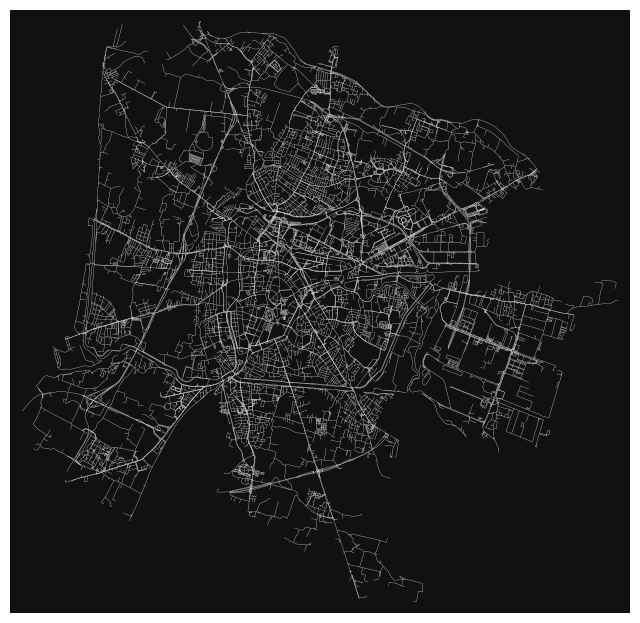

In [3]:
G_padova = ox.graph_from_place(PLACE_NAME, network_type="walk", simplify=True)
G_padova = ox.get_undirected(G_padova)
fig, ax = ox.plot_graph(G_padova, node_size=0, edge_color="w", node_color="r", edge_linewidth=0.2)

In [4]:
len(G_padova)

20360

The number of nodes for the Padua street network is too large, since complex interchanges and roundabouts form clusters of nodes where the real connection is essentialy only one. So the next step is to simplify the street network, assuming nodes at maximum 15 meters are the same intersection

In [5]:
G_proj = ox.project_graph(G_padova)
G_padova_simplified = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G_padova_simplified)

5462

### Consolidation example

To make clear what's happening, let's make an example to see it visually.
This is the graph before simplification:

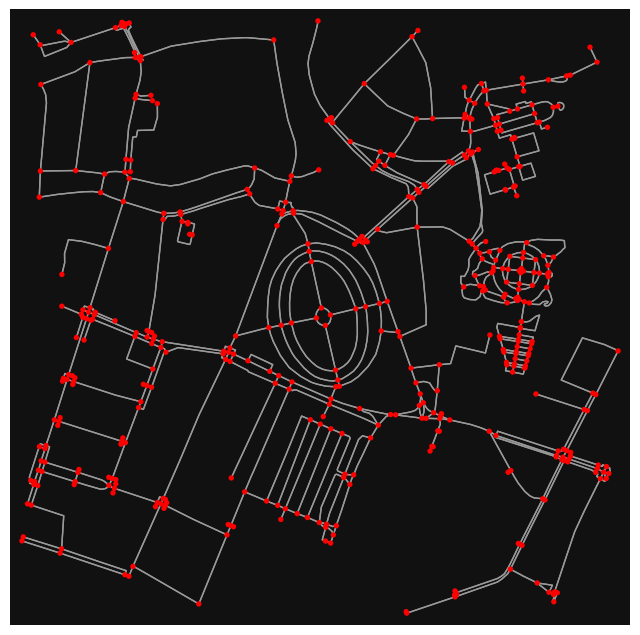

In [6]:
point = 45.39840,11.87644
G_ex = ox.graph_from_point(point, network_type="walk", dist=500)
fig, ax = ox.plot_graph(G_ex, node_color="r")

It is interesting to observe that complex intersections are represented by multiple nodes, which is not what we need.
After consolidating the intersections, the graph becomes:

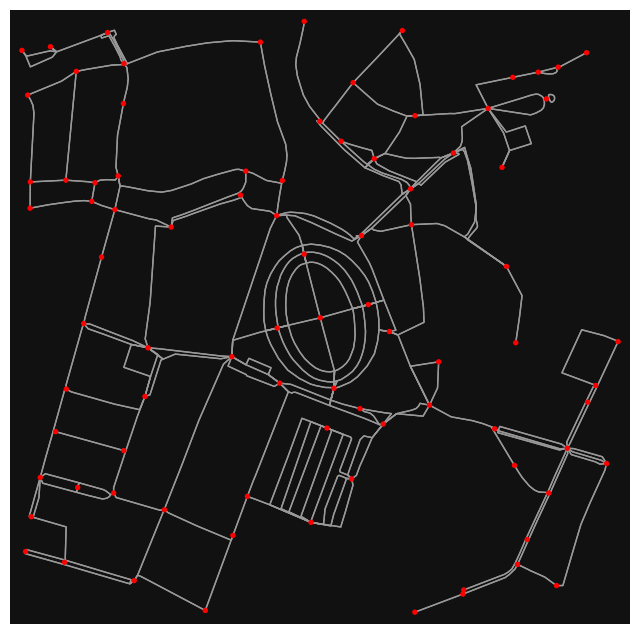

In [7]:
G_proj_ex = ox.project_graph(G_ex)
G_ex_simple = ox.consolidate_intersections(G_proj_ex, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = ox.plot_graph(G_ex_simple, node_color="r")

which conforms much better to modeling.
The drawback is an over-simplification of some connections, like the section at east of Prato della Valle, which is actually the Botanic garden, so simplifying to few nodes is not actually a big deal.
Another example is in the South, where there are a few close parallel connections, but it turns out to be a parking spot, so it is no big deal to over-simplify it.

In [8]:
ox.save_graph_shapefile(G_padova_simplified, filepath='data/graph/', encoding='utf-8')

Just to see that everything worked, let's print the GeoDataframes

In [9]:
nodes_gdf = gpd.read_file('data/graph/nodes.shp')
edges_gdf = gpd.read_file('data/graph/edges.shp')
print(nodes_gdf.crs, edges_gdf.crs, G_padova_simplified.graph['crs'], G_padova.graph['crs'])

EPSG:32632 EPSG:32632 EPSG:32632 epsg:4326


In [10]:
nodes_gdf.head()

,osmid,osmid_orig,x,y,street_cou,lon,lat,highway,ref,geometry
0,0,"[141540485, 254672751, 197522982, 254672878, 2...",724701.900173,5.034203e+06,0,NaN,NaN,None,None,POINT (724701.900 5034203.206)
1,1,"[141542464, 522060005, 10964558191, 1855945754...",725125.264890,5.032994e+06,0,NaN,NaN,None,None,POINT (725125.265 5032993.789)
2,2,"[522060014, 206354760, 5392711449, 5392711456,...",725269.805793,5.032962e+06,0,NaN,NaN,None,None,POINT (725269.806 5032962.359)
3,3,"[141542473, 5792497355, 7086991412, 5798251594...",726160.105869,5.032901e+06,0,NaN,NaN,None,None,POINT (726160.106 5032900.781)
4,4,"[1113558376, 1101896841, 1101896807]",725349.659264,5.032934e+06,0,NaN,NaN,None,None,POINT (725349.659 5032934.463)


In [11]:
edges_gdf.head(10)

,u,v,key,osmid,highway,oneway,reversed,length,from,to,...,maxspeed,bridge,access,service,area,junction,tunnel,est_width,ref,geometry
0,0,235,0,244968982,path,0,False,262.005714,0,235,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724701.900 5034203.206, 724666.149..."
1,0,235,1,41224006,tertiary,0,False,205.686533,0,235,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724701.900 5034203.206, 724674.181..."
2,0,235,2,"[23516585, 960693916]","['footway', 'residential']",0,"[False, True]",269.826579,0,235,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724701.900 5034203.206, 724686.435..."
3,0,235,3,244969034,path,0,True,219.053507,0,235,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724701.900 5034203.206, 724678.669..."
4,0,233,0,244969016,path,0,False,269.193872,233,0,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724714.668 5034196.773, 724771.919..."
5,0,628,0,"[244969011, 244969037]",path,0,True,803.842541,628,0,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724832.621 5033954.570, 724715.964..."
6,0,643,0,24572542,residential,0,True,145.182149,643,0,...,30,None,None,None,None,None,None,None,None,"LINESTRING (724715.964 5034194.706, 724773.190..."
7,0,990,0,244968982,path,0,False,128.726457,990,0,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724731.069 5034143.777, 724711.092..."
8,0,990,1,202777623,tertiary,0,False,126.799449,990,0,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724731.069 5034143.777, 724716.408..."
9,1,2,1,172020585,tertiary,0,True,293.162769,1,2,...,None,None,None,None,None,None,None,None,None,"LINESTRING (725125.265 5032993.789, 725226.772..."


In [12]:
default_crs = str(G_padova_simplified.graph["crs"])
default_crs

'EPSG:32632'

In [13]:
ox.save_graph_shapefile(G_ex_simple, filepath='data/graph_ex/', encoding='utf-8')
nodes_ex = gpd.read_file('data/graph_ex/nodes.shp')
edges_ex = gpd.read_file('data/graph_ex/edges.shp')

## Point of Interests (POIs)
Let's define the POIs we are interested in, the full table can be found in the presentation paper.

In [14]:
# just for easy scalability
buildings_names = {
    "education": ["school", "kindergarten", "library"],
    "bank": ["bank", "atm"],
    "healthcare": ["clinic", "doctors", "hospital", "pharmacy"],
    "transportation": ["stop_position"],
    "food": ["supermarket","convenience","greengrocer"]
}

For each group, let's create a GeoDataFrame and save it in another dictionary for easy access.

In [15]:
buildings_gdf = dict.fromkeys(buildings_names.keys())
for category in buildings_gdf.keys():
    # set the key (based on OSM specification)
    poi_key = "amenity"
    if category == "transportation":
        poi_key = "public_transport"
    if category == "food":
        poi_key = "shop"

    # set the value (simply the array)
    poi_value = buildings_names[category]

    # create the GeoDataFrame
    buildings_gdf[category] = ox.features_from_place(
            PLACE_NAME,
            {poi_key: poi_value}
        )

    # convert to the same crs as the graph
    buildings_gdf[category] = ox.project_gdf(buildings_gdf[category], to_crs=default_crs)

In [16]:
for category in buildings_names.keys():
    # create lon and lat columns
    buildings_gdf[category]['geometry'] = buildings_gdf[category]['geometry'].apply(lambda p: p.centroid if p.geom_type == 'Polygon' else p)
    buildings_gdf[category]['lon'] = buildings_gdf[category]['geometry'].apply(lambda p: p.x)
    buildings_gdf[category]['lat'] = buildings_gdf[category]['geometry'].apply(lambda p: p.y)

    # create type column
    buildings_gdf[category]['type'] = category
    
    #select only lon, lat and geometry columns
    buildings_gdf[category] = buildings_gdf[category][['lon', 'lat', 'geometry','type']]
    
    # save to file
    buildings_gdf[category].to_file(f"./data/pois/{category}.gpkg", driver="GPKG")


 education 

Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 1/140 (0.71%)
NOTE: duplication in node coordinates keys
Nodes count: 5742
Node coordinates key count: 5740
Missing 'from' nodes: 0
Missing 'to' nodes: 0

 bank 

Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 113/113 (100.00%)
NOTE: duplication in node coordinates keys
Nodes count: 5968
Node coordinates key count: 5965
Missing 'from' nodes: 0
Missing 'to' nodes: 0

 healthcare 

Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 95/95 (100.00%)
NOTE: duplication in node coordinates keys
Nodes count: 6158
Node coordin

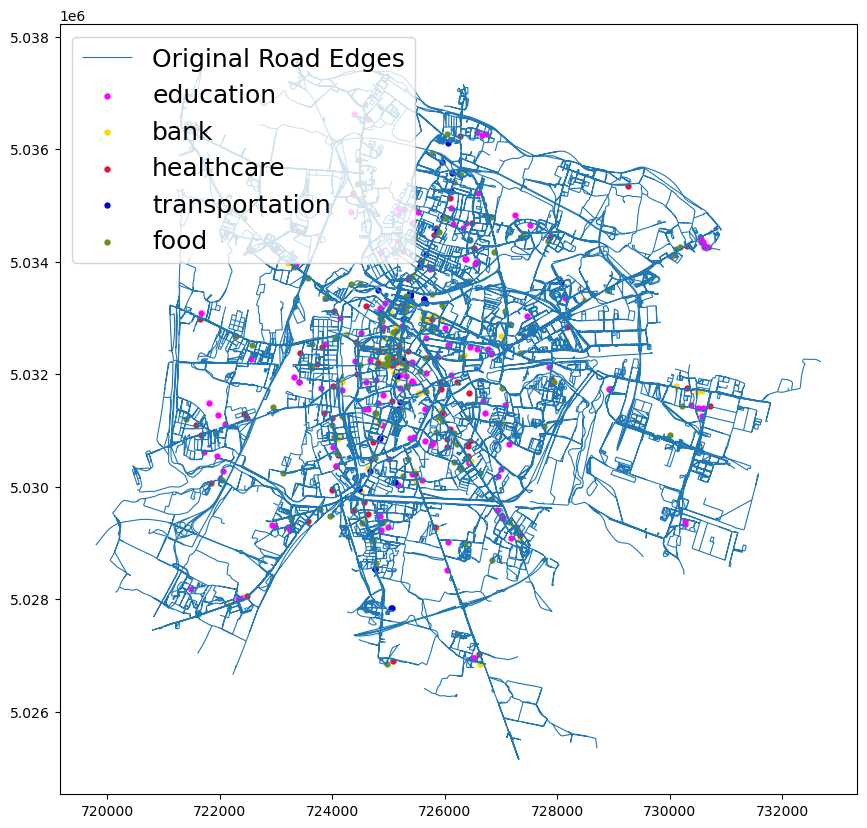

In [22]:
# connect pois
pois_colors = {
    "education": "magenta",
    "bank": "gold",
    "healthcare": "crimson",
    "transportation": "mediumblue",
    "food": "olivedrab"
}

ax = edges_gdf.plot(linewidth=0.8, figsize=(18,10), label='Original Road Edges')

nodes_gdf_poi = nodes_gdf
edges_gdf_poi = edges_gdf

i = 0
for category in buildings_gdf.keys():
    pois = gpd.read_file(f'./data/pois/{category}.gpkg')
    pois['key'] = 9991000000 + 1000000*i + pois.index 
    
    print('\n', category, '\n')
    nodes_gdf_poi, edges_gdf_poi = connect_poi(pois, nodes_gdf_poi, edges_gdf_poi, key_col='key', path=None, counter=i)
    i=i+1
    pois.plot(color=pois_colors[category], marker='.', markersize=50, ax=ax, label=category)
    
ax.legend(loc=2, fontsize=18)

In [23]:
#Create final graph G to be saved
nodes_gdf_poi = nodes_gdf_poi.set_index('osmid')
edges_gdf_poi = edges_gdf_poi.set_index(['u', 'v', 'key']) 

G = ox.utils_graph.graph_from_gdfs(nodes_gdf_poi, edges_gdf_poi)

In [24]:
#Remove nodes with osmid=nan and empty entries
import math
nodes, data = zip(*G.nodes(data=True))

c = 0
removables = []
for d in data:
    if math.isnan(nodes[c]) or d == {}:
        print(c, ":", nodes[c], "&", d, "->", list(G.nodes())[c])
        removables.append(list(G.nodes())[c])
    c=c+1

G.remove_nodes_from(removables)

5451 : nan & {} -> nan
5453 : nan & {} -> nan
5456 : nan & {} -> nan
5458 : nan & {} -> nan
5461 : nan & {} -> nan
5466 : nan & {} -> nan
5469 : nan & {} -> nan
5478 : nan & {} -> nan
5490 : nan & {} -> nan
5501 : nan & {} -> nan
5506 : nan & {} -> nan
5509 : nan & {} -> nan
5513 : nan & {} -> nan
5516 : nan & {} -> nan
5528 : nan & {} -> nan
5529 : nan & {} -> nan
5532 : nan & {} -> nan
5534 : nan & {} -> nan
5535 : nan & {} -> nan
5539 : nan & {} -> nan
5542 : nan & {} -> nan
5547 : nan & {} -> nan
5550 : nan & {} -> nan
5557 : nan & {} -> nan
5560 : nan & {} -> nan
5565 : nan & {} -> nan
5567 : nan & {} -> nan
5572 : nan & {} -> nan
5576 : nan & {} -> nan
5581 : nan & {} -> nan
5585 : nan & {} -> nan
5588 : nan & {} -> nan
5598 : nan & {} -> nan
5600 : nan & {} -> nan
5602 : nan & {} -> nan
5604 : nan & {} -> nan
5610 : nan & {} -> nan
5616 : nan & {} -> nan
5620 : nan & {} -> nan
5622 : nan & {} -> nan
5624 : nan & {} -> nan
5632 : nan & {} -> nan
5792 : nan & {} -> nan
5797 : nan 

In [25]:
ox.save_graph_shapefile(G, filepath='data/graph/', encoding='utf-8')

/var/folders/j8/t8w0t18x5_b9rp7q_xf7j7dm0000gn/T/ipykernel_92718/4258711556.py:1: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  ox.save_graph_shapefile(G, filepath='data/graph/', encoding='utf-8')
